In [1]:
# %load_ext autoreload
# %autoreload 2
#%matplotlib widget
from pathlib import Path

import numpy as np
import numpy.typing as npt
import xarray as xr
import cmcrameri.cm as cmc
import scienceplots
from scipy.interpolate import CubicSpline, griddata, make_interp_spline, PchipInterpolator
import scipy.constants as constants
import scipy.fft as fft
import scipy.signal as signal
import scipy.linalg as linalg
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.ticker as tkr
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import stereoid.oceans.tops_model as TOPS
import drama.io.cfg as cfg

import stereoid.utils.config as st_config
from stereoid.oceans.tc_scenario import tc_wake_kudry19, tc_wake_scene

In [2]:
user_cfg_path = Path("~/Code/WSOA Scientific Workbench/PAR/user.cfg").expanduser()
# path to PAR file
# Set this to the directory of your data and model results
paths = st_config.parse(user_cfg_path, section="Paths")
parfile = paths["par"] / "Hrmny_XTI_finalists_timeline.cfg"
par_data = cfg.ConfigFile(parfile)

/home/andreas/Code/stereoid_public/stereoid /home/andreas/Code/WSOA Scientific Workbench/PAR/user.cfg


In [3]:
tc_path = paths["results"] / "Maria TC data.nc"
l1_path = paths["results"] / "L1data.nc"
h_std_path = paths["results"] / "h_std.nc"

In [4]:
l1_ds = xr.open_dataset(l1_path)
tc_ds = xr.open_dataset(tc_path)
l1_ds = l1_ds.rename({"gr": "grg"})
l1_ds = l1_ds.rename_vars({"incm": "inc"})
tc_ds = tc_ds.rename({"gr": "grg"})
tc_ds = tc_ds.rename_vars({"incm": "inc"})
h_std_ds = xr.open_dataset(h_std_path)

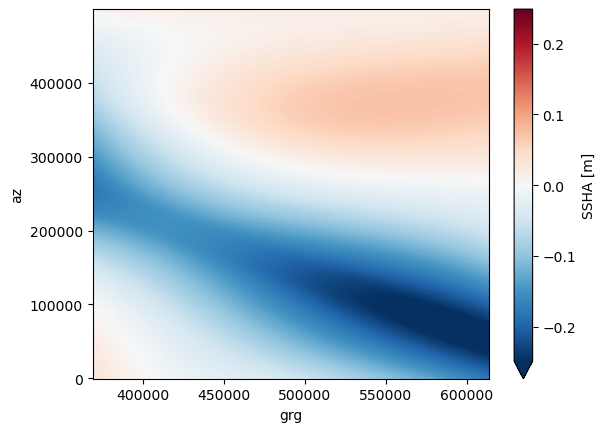

In [5]:
im = tc_ds.SSHA.plot(robust=True)
# im.axes.set_aspect("equal")

In [6]:
ssha = signal.resample_poly(tc_ds.SSHA.to_numpy(), 5, 1, axis=0, padtype="smooth")
num_az = tc_ds.SSHA.shape[0] * 5
az = tc_ds.az.to_numpy()
az_new = np.arange(0, num_az) * (az[1] - az[0]) * len(az) / float(num_az) + az[0]
ssha = signal.resample_poly(ssha, 5, 1, axis=1, padtype="smooth")
num_grg = tc_ds.SSHA.shape[1] * 5
grg = tc_ds.grg.to_numpy()
grg_new = np.arange(0, num_grg) * (grg[1] - grg[0]) * len(grg) / float(num_grg) + grg[0]

In [7]:
tc_ds = tc_ds.drop_vars("SSHA")
tc_ds = tc_ds.interp(
    grg=grg_new, az=az_new, method="linear", kwargs={"fill_value": "extrapolate"}
)
tc_ds = tc_ds.assign(SSHA=(["az", "grg"], ssha))
tc_ds = tc_ds.assign_attrs(
    resolution=1000, resolution_units="m", posting=200, posting_units="m"
)

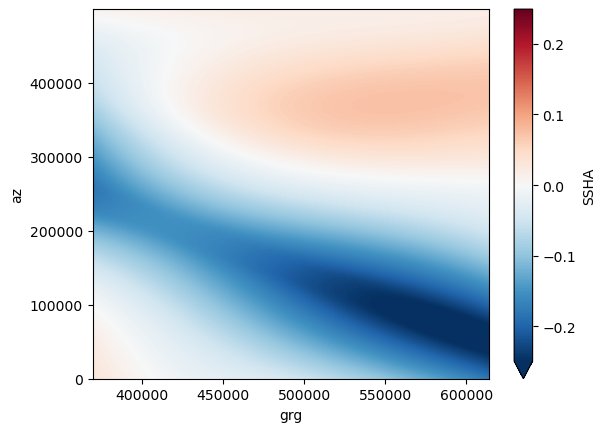

In [8]:
im = tc_ds.SSHA.plot(robust=True)

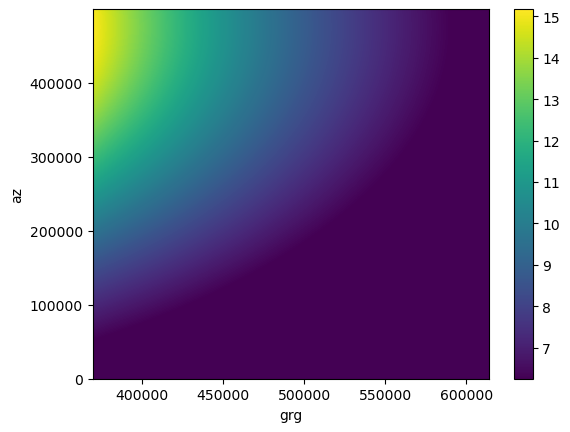

In [9]:
np.sqrt(tc_ds.U10s_x**2 + tc_ds.U10s_y**2).plot()

In [10]:
asc_lats = h_std_ds.latitude.isel(time=slice(0, 2963)).to_numpy()
inc_grid = np.zeros_like(asc_lats) + h_std_ds.incidence.to_numpy()

In [11]:
l1_lats = l1_ds.latitude
l1_inc = np.zeros_like(l1_lats) + np.rad2deg(l1_ds.inc).to_numpy()

In [12]:
irregular_grid_points = np.stack([asc_lats.ravel(), inc_grid.ravel()], -1)  # shape (N, 2) in 2d
out_grid = (l1_lats, l1_inc)

In [13]:
def interp_to_grid(u, in_grid, out_grid):
    z = griddata(in_grid, u.flatten(), out_grid, fill_value = np.nan)
    return z

In [14]:
h_std_grid = griddata(
    irregular_grid_points,
    h_std_ds.sel(formation=4, wind_sp=7.5)
    .isel(time=slice(0, 2963))
    .height_std.to_numpy()
    .flatten(),
    out_grid,
    method="cubic"
)

h_amb_grid = griddata(
    irregular_grid_points,
    h_std_ds.sel(formation=4, wind_sp=7.5)
    .isel(time=slice(0, 2963))
    .h_amb.to_numpy()
    .flatten(),
    out_grid,
    method="cubic"
)

In [15]:
h_std_grid = signal.resample_poly(h_std_grid, 5, 1, axis=0, padtype="smooth")
h_std_grid = signal.resample_poly(h_std_grid, 5, 1, axis=1, padtype="smooth")
h_amb_grid = signal.resample_poly(h_amb_grid, 5, 1, axis=0, padtype="smooth")
h_amb_grid = signal.resample_poly(h_amb_grid, 5, 1, axis=1, padtype="smooth")

In [16]:
h_std_roi = xr.zeros_like(tc_ds.SSHA)
h_std_roi += h_std_grid
h_amb_roi = xr.zeros_like(tc_ds.SSHA)
h_amb_roi += h_amb_grid

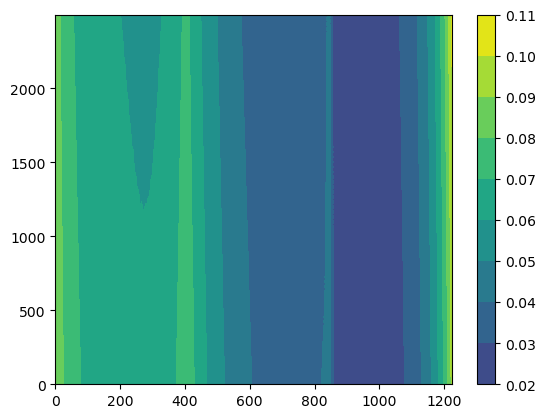

In [17]:
fig, ax = plt.subplots()
im = ax.contourf(h_std_grid, vmin=0)
fig.colorbar(im, ax=ax)

In [18]:
latitude = tc_ds.latitude.isel(grg=0)
parameters = TOPS.tops_parameters(latitude, user_cfg_path, "Hrmny_XTI_finalists_timeline.cfg")
tops_acqs = TOPS.TOPSAcquisitions(parameters, 0)

/home/andreas/Code/stereoid_public/stereoid /home/andreas/Code/WSOA Scientific Workbench/PAR/user.cfg


In [19]:
tc_iw1 = tops_acqs.extract_subswath(tc_ds, 1)
tc_iw2 = tops_acqs.extract_subswath(tc_ds, 2, True)
tc_iw3 = tops_acqs.extract_subswath(tc_ds, 3, True)

In [20]:
az_z, grg_g = np.meshgrid(tc_iw1.az, tc_iw1.grg, sparse=True, indexing="ij")

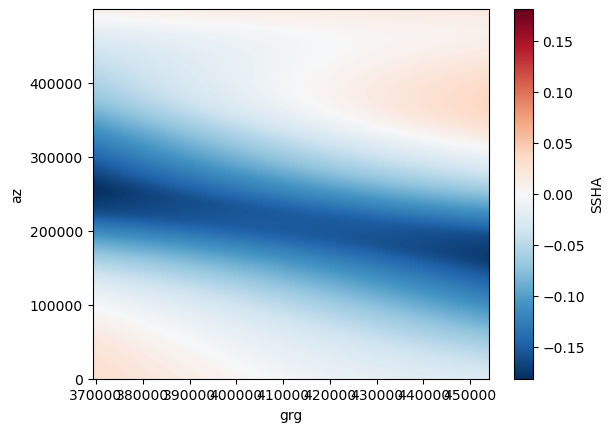

In [21]:
im = tc_iw1.SSHA.plot()

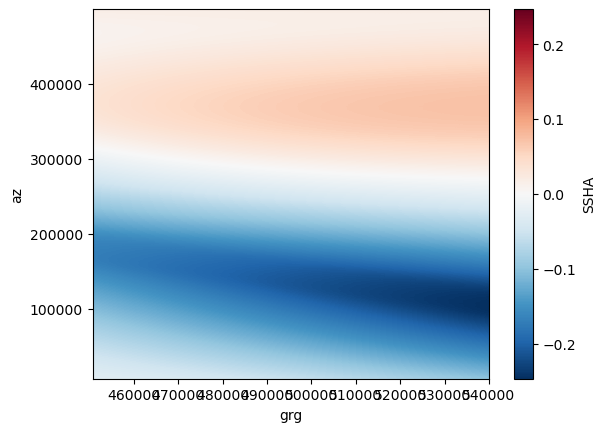

In [22]:
im = tc_iw2.SSHA.plot()

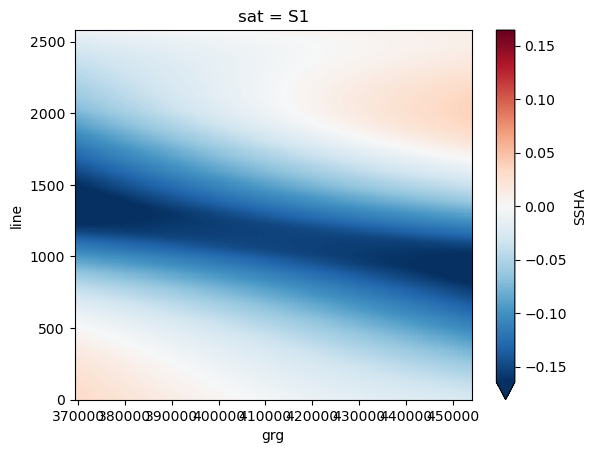

In [23]:
mosaic_iw1 = tops_acqs.mosaic(tc_iw1, 24, False, False, "SSHA")
im = mosaic_iw1.sel(sat="S1").SSHA.plot(robust=True)

In [24]:
num_samples = 70_000
fs = 1000
Ts = 1 / fs
time_phase = np.linspace(0, num_samples * Ts, num_samples, endpoint=False)

In [25]:
rng = np.random.default_rng(123456)

In [44]:
shifted_freq2 = fft.fftshift(fft.fftfreq(2*num_samples, 1 / (2*fs)))
freq_mask2 = (shifted_freq2 <= 2) & (shifted_freq2 >= -2)

In [26]:
P = np.zeros(num_samples)
n0 = int(np.floor(num_samples / 2)) + 1
shifted_freq = fft.fftshift(fft.fftfreq(num_samples, 1 / fs))
freq_mask = (shifted_freq <= 2) & (shifted_freq >= -2)
P[freq_mask] = 14 / (np.sum(freq_mask) * fs / num_samples)
phase = rng.uniform(0, 2 * np.pi, num_samples)
A = np.sqrt(num_samples * fs * P) * np.exp(1j * phase)
A[1 : n0 - 1] = np.flipud(np.conj(A[n0:]))
A[0] = np.abs(A[0])
A[n0 - 1] = P[n0 - 1]
phase_error = fft.ifft(fft.ifftshift(A))
phase_error = np.real(phase_error)

In [ ]:
b1_iw1 = tops_acqs.get_burst(tc_iw1, 1, False, "SSHA")
b1_iw2 = tops_acqs.get_burst(tc_iw2, 1, False, "SSHA")

In [ ]:
spl = CubicSpline(latitude, parameters.r_s)
r_sl_b1 = spl(b1_iw1.latitude.isel(grg=0))

In [ ]:
Ka = (
    2
    * parameters.mean_ground_rectilinear_v() ** 2
    * par_data.sar.f0
    / (constants.c * r_sl_b1)
)

In [ ]:
look_centre_time_iw1 = par_data.IWS.proc_bw[0] * 0.25 / Ka
mean_look_centre_time_iw1 = np.mean(look_centre_time_iw1)

look_centre_time_iw2 = par_data.IWS.proc_bw[1] * 0.25 / Ka
mean_look_centre_time_iw2 = np.mean(look_centre_time_iw2)

look_centre_time_iw3 = par_data.IWS.proc_bw[2] * 0.25 / Ka
mean_look_centre_time_iw3 = np.mean(look_centre_time_iw3)
sample_look_offset = int(np.ceil(mean_look_centre_time_iw1 / Ts))

In [ ]:
def get_subswath_timeline(subswath, tops_acqs, n_bursts, offset):
    sensing_times = []
    for i in range(n_bursts):
        sensing_time = tops_acqs.get_burst(subswath, i+1, False, "SSHA").sensing_time.to_numpy()
        sensing_time += offset
        sensing_times.append(sensing_time)
    return sensing_times

In [ ]:
sensing_times_iw1 = get_subswath_timeline(tc_iw1, tops_acqs, 24, sample_look_offset * Ts)
sensing_times_iw2 = get_subswath_timeline(tc_iw2, tops_acqs, 24, sample_look_offset * Ts)
sensing_times_iw3 = get_subswath_timeline(tc_iw3, tops_acqs, 24, sample_look_offset * Ts)

In [ ]:
def sinc_interpolation(x: npt.NDArray, s: npt.NDArray, u: npt.NDArray) -> npt.NDArray:
    """Whittaker–Shannon interpolation.
    Args:
        x (NDArray): signal to be interpolated, can be 1D or 2D
        s (NDArray): time points of x (*s* for *samples*) 
        u (NDArray): time points of y (*u* for *upsampled*)
    Returns:
        NDArray: interpolated signal at time points *u*
    """
    sinc_kernel = np.sinc((u - s[:, np.newaxis])/(s[1]-s[0]))

    return np.dot(x, sinc_kernel)

In [ ]:
def interpolate_phase_signal_subswath(phase_signal, phase_time, sensing_times):
    phase_signals = []
    for time in sensing_times:
        phase_error_in_burst = sinc_interpolation(phase_signal, phase_time, time)
        phase_signals.append(phase_error_in_burst)
    return phase_signals

In [ ]:
phase_error_iw1 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw1)
phase_error_iw2 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw2)
phase_error_iw3 = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw3)

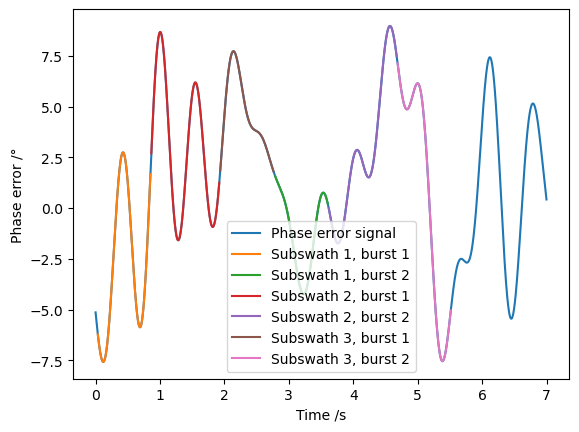

In [ ]:
fig, ax = plt.subplots()
ax.plot(time_phase[0:7000], phase_error[0:7000], label="Phase error signal")
ax.plot(sensing_times_iw1[0], phase_error_iw1[0], label="Subswath 1, burst 1")
ax.plot(sensing_times_iw1[1], phase_error_iw1[1], label="Subswath 1, burst 2")
ax.plot(sensing_times_iw2[0], phase_error_iw2[0], label="Subswath 2, burst 1")
ax.plot(sensing_times_iw2[1], phase_error_iw2[1], label="Subswath 2, burst 2")
ax.plot(sensing_times_iw3[0], phase_error_iw3[0], label="Subswath 3, burst 1")
ax.plot(sensing_times_iw3[1], phase_error_iw3[1], label="Subswath 3, burst 2")
ax.set_xlabel("Time /s")
ax.set_ylabel("Phase error /°")
ax.legend()

In [ ]:
mosaic_iw1 = tops_acqs.mosaic(tc_iw1, 24, False, False, "SSHA")
mosaic_iw2 = tops_acqs.mosaic(tc_iw2, 24, False, False, "SSHA")
mosaic_iw3 = tops_acqs.mosaic(tc_iw3, 24, False, False, "SSHA")

In [ ]:
phase_error_tiled = []
for (iw1, iw2, iw3) in zip(phase_error_iw1, phase_error_iw2, phase_error_iw3):
    phase_error_tiled.append(iw1)
    phase_error_tiled.append(iw2)
    phase_error_tiled.append(iw3)
phase_error_tiled = np.concatenate(phase_error_tiled)

In [ ]:
phase_error_iw1 = np.concatenate(phase_error_iw1)
phase_error_iw2 = np.concatenate(phase_error_iw2)
phase_error_iw3 = np.concatenate(phase_error_iw3)

In [ ]:
height_error_clock_iw1 = (
    np.deg2rad(phase_error_iw1[:, np.newaxis])
    / (2 * np.pi)
    * h_amb_roi.sel(grg=mosaic_iw1.grg, az=mosaic_iw1.az)
)
mosaic_iw1_error = mosaic_iw1.SSHA + height_error_clock_iw1

height_error_clock_iw2 = (
    np.deg2rad(phase_error_iw2[:, np.newaxis])
    / (2 * np.pi)
    * h_amb_roi.sel(grg=mosaic_iw2.grg, az=mosaic_iw2.az)
)
mosaic_iw2_error = mosaic_iw2.SSHA + height_error_clock_iw2

height_error_clock_iw3 = (
    np.deg2rad(phase_error_iw3[:, np.newaxis])
    / (2 * np.pi)
    * h_amb_roi.sel(grg=mosaic_iw3.grg, az=mosaic_iw3.az)
)
mosaic_iw3_error = mosaic_iw3.SSHA + height_error_clock_iw3

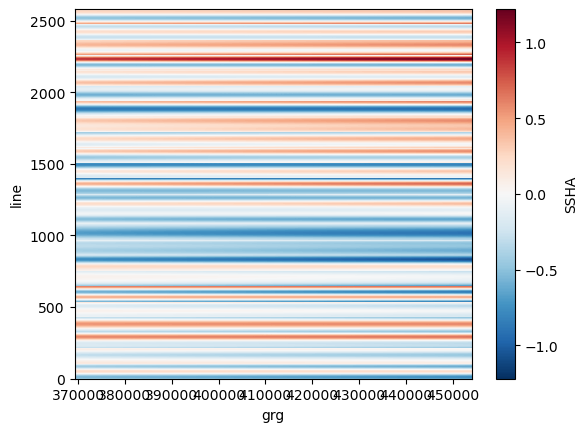

In [ ]:
mosaic_iw1_error.plot()

In [ ]:
Ts_iw1 = sensing_times_iw1[0][1] - sensing_times_iw1[0][0]
Ts_iw2 = sensing_times_iw2[0][1] - sensing_times_iw2[0][0]
Ts_iw3 = sensing_times_iw3[0][1] - sensing_times_iw3[0][0]

In [ ]:
sensing_times_iw1_l1_s = [t - mean_look_centre_time_iw1 + Ts_iw1/2 for t in sensing_times_iw1]
sensing_times_iw1_l2_s = [t + mean_look_centre_time_iw1 + Ts_iw1/2 for t in sensing_times_iw1]

sensing_times_iw2_l1_s = [t - mean_look_centre_time_iw2 + Ts_iw2/2 for t in sensing_times_iw2]
sensing_times_iw2_l2_s = [t + mean_look_centre_time_iw2 + Ts_iw2/2 for t in sensing_times_iw2]

sensing_times_iw3_l1_s = [t - mean_look_centre_time_iw3 + Ts_iw3/2 for t in sensing_times_iw3]
sensing_times_iw3_l2_s = [t + mean_look_centre_time_iw3 + Ts_iw3/2 for t in sensing_times_iw3]

In [ ]:
phase_error_iw1_l1_s = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw1_l1_s)
phase_error_iw1_l2_s = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw1_l2_s)

phase_error_iw2_l1_s = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw2_l1_s)
phase_error_iw2_l2_s = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw2_l2_s)

phase_error_iw3_l1_s = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw3_l1_s)
phase_error_iw3_l2_s = interpolate_phase_signal_subswath(phase_error, time_phase, sensing_times_iw3_l2_s)

In [ ]:
dt_iw1 = sensing_times_iw1_l2_s[0][0] - sensing_times_iw1_l1_s[0][0]
dt_iw2 = sensing_times_iw2_l2_s[0][0] - sensing_times_iw2_l1_s[0][0]
dt_iw3 = sensing_times_iw3_l2_s[0][0] - sensing_times_iw3_l1_s[0][0]

In [ ]:
_, subswath_1_to_2_line_offset, _ = np.intersect1d(
    mosaic_iw1_error.az,
    mosaic_iw2_error.az[0],
    assume_unique=False,
    return_indices=True,
)
subswath_1_to_2_line_offset = subswath_1_to_2_line_offset[0]
_, subswath_2_to_3_line_offset, _ = np.intersect1d(
    mosaic_iw2_error.az,
    mosaic_iw3_error.az[0],
    assume_unique=False,
    return_indices=True,
)
subswath_1_to_3_line_offset = subswath_2_to_3_line_offset[0] + subswath_1_to_2_line_offset

In [ ]:
sensing_times_tiled = []
for i in range(len(phase_error_iw1_l1_s)):
    for t in (sensing_times_iw1[i], sensing_times_iw2[i], sensing_times_iw3[i]):
        sensing_times_tiled.append(t)

In [ ]:
sensing_times_tiled = np.concatenate(sensing_times_tiled)

In [ ]:
_, time_iw1_ind, _ = np.intersect1d(
    sensing_times_tiled,
    np.concatenate(sensing_times_iw1),
    assume_unique=True,
    return_indices=True,
)
_, time_iw2_ind, _ = np.intersect1d(
    sensing_times_tiled,
    np.concatenate(sensing_times_iw2),
    assume_unique=True,
    return_indices=True,
)
_, time_iw3_ind, _ = np.intersect1d(
    sensing_times_tiled,
    np.concatenate(sensing_times_iw3),
    assume_unique=True,
    return_indices=True,
)

In [ ]:
mosaic_iw2_error["line"] = mosaic_iw2_error.line + subswath_1_to_2_line_offset

In [ ]:
mosaic_iw3_error["line"] = mosaic_iw3_error.line + subswath_1_to_3_line_offset

In [ ]:
mosaic_iw12 = mosaic_iw1_error.isel(
    grg=mosaic_iw1_error.grg < mosaic_iw2_error.grg.isel(grg=0)
).combine_first(mosaic_iw2_error)
mosaic_iw123 = mosaic_iw12.isel(grg= mosaic_iw12.grg < mosaic_iw3_error.grg.isel(grg=0)).combine_first(mosaic_iw3_error)

In [ ]:
phase_error_der_n = []
ders_iw1_n = []
ders_iw2_n = []
ders_iw3_n = []
for i in range(len(phase_error_iw1_l1_s)):
    der_iw1_n = (phase_error_iw1_l2_s[i] - phase_error_iw1_l1_s[i]) / dt_iw1
    der_iw2_n = (phase_error_iw2_l2_s[i] - phase_error_iw2_l1_s[i]) / dt_iw2
    der_iw3_n = (phase_error_iw3_l2_s[i] - phase_error_iw3_l1_s[i]) / dt_iw3
    for der in (der_iw1_n, der_iw2_n, der_iw3_n):
        phase_error_der_n.append(der)
    ders_iw1_n.append(der_iw1_n)
    ders_iw2_n.append(der_iw2_n)
    ders_iw3_n.append(der_iw3_n)

In [ ]:
ph_std_roi = 2 * np.pi / h_amb_roi * h_std_roi 

In [ ]:
ph_std_iw1 = ph_std_roi.sel(az=mosaic_iw1.az, grg=mosaic_iw1.grg)
ph_std_iw2 = ph_std_roi.sel(az=mosaic_iw2.az, grg=mosaic_iw2.grg)
ph_std_iw3 = ph_std_roi.sel(az=mosaic_iw3.az, grg=mosaic_iw3.grg)

In [ ]:
line_burst_beg = 0
for i, der in enumerate(ders_iw1_n):
    len_t = len(der)
    ph_std_i = ph_std_iw1.isel(line=slice(line_burst_beg, line_burst_beg + len_t))
    ph_std_m = np.sqrt(
        np.rad2deg((ph_std_i**2).mean(dim="grg")) * 4 / len(ph_std_i.grg)
    )
    ders_iw1_n[i] = der + (rng.standard_normal(len_t) * ph_std_m)
    line_burst_beg += len_t

line_burst_beg = 0
for i, der in enumerate(ders_iw2_n):
    len_t = len(der)
    ph_std_i = ph_std_iw2.isel(line=slice(line_burst_beg, line_burst_beg + len_t))
    ph_std_m = np.sqrt(
        np.rad2deg((ph_std_i**2).mean(dim="grg")) * 4 / len(ph_std_i.grg)
    )
    ders_iw2_n[i] = der + (rng.standard_normal(len_t) * ph_std_m)
    line_burst_beg += len_t

line_burst_beg = 0
for i, der in enumerate(ders_iw3_n):
    len_t = len(der)
    ph_std_i = ph_std_iw3.isel(line=slice(line_burst_beg, line_burst_beg + len_t))
    ph_std_m = np.sqrt(
        np.rad2deg((ph_std_i**2).mean(dim="grg")) * 4 / len(ph_std_i.grg)
    )
    ders_iw3_n[i] = der + (rng.standard_normal(len_t) * ph_std_m)
    line_burst_beg += len_t

In [ ]:
phase_error_der_n = []
for i in range(len(ders_iw1_n)):
    der_iw1 = ders_iw1_n[i]
    der_iw2 = ders_iw2_n[i]
    der_iw3 = ders_iw3_n[i]
    spl = CubicSpline(
        np.concatenate(
            [sensing_times_iw1[i][:-1] + Ts_iw1 / 2, sensing_times_iw2[i] + Ts_iw2 / 2]
        ),
        np.concatenate([der_iw1[:-1], der_iw2]),
    )
    der_iw1[-1] = spl((sensing_times_iw1[i][-1] + sensing_times_iw2[i][0]) / 2)
    spl = CubicSpline(
        np.concatenate(
            [sensing_times_iw2[i][:-1] + Ts_iw2 / 2, sensing_times_iw3[i] + Ts_iw3 / 2]
        ),
        np.concatenate([der_iw2[:-1], der_iw3]),
    )
    der_iw2[-1] = spl((sensing_times_iw2[i][-1] + sensing_times_iw3[i][0]) / 2)
    if i < len(phase_error_iw1_l1_s) - 1:
        der_iw1_n = ders_iw1_n[i + 1]
        spl = CubicSpline(
            np.concatenate(
                [
                    sensing_times_iw3[i][:-1] + Ts_iw3 / 2,
                    sensing_times_iw1[i + 1] + Ts_iw1 / 2,
                ]
            ),
            np.concatenate([der_iw3[:-1], der_iw1_n]),
        )
        der_iw3[-1] = spl((sensing_times_iw3[i][-1] + sensing_times_iw1[i + 1][0]) / 2)
    for der in (der_iw1, der_iw2, der_iw3):
        phase_error_der_n.append(der)

In [ ]:
phase_error_der_n = np.concatenate(phase_error_der_n)

In [ ]:
num_rows = len(phase_error_der_n)-1
num_cols = len(phase_error_der_n)
delta = np.zeros((num_rows, num_cols))
difference_kernel = np.array([-1, 1])
for i in range(num_rows):
    delta[i, i:i+2] = difference_kernel
delta /= np.diff(sensing_times_tiled)[:, np.newaxis]

In [ ]:
def find_overlap_indices(subswath_mosaic, sensing_times, t_offset):
    first_duplicates_ind = (
        subswath_mosaic.SSHA.swap_dims({"line": "az"})
        .get_index("az")
        .duplicated("last")
        .nonzero()[0]
    )
    last_duplicates_ind = (
        subswath_mosaic.SSHA.swap_dims({"line": "az"})
        .get_index("az")
        .duplicated("first")
        .nonzero()[0]
    )
    _, first_duplicates_ind, _ = np.intersect1d(
        sensing_times,
        subswath_mosaic.sensing_time[first_duplicates_ind] + t_offset,
        assume_unique=True,
        return_indices=True,
    )
    _, last_duplicates_ind, _ = np.intersect1d(
        sensing_times,
        subswath_mosaic.sensing_time[last_duplicates_ind] + t_offset,
        assume_unique=True,
        return_indices=True,
    )
    return first_duplicates_ind, last_duplicates_ind

In [ ]:
iw1_first_duplicates_ind, iw1_last_duplicates_ind = find_overlap_indices(
    mosaic_iw1, sensing_times_tiled, sample_look_offset * Ts
)
iw2_first_duplicates_ind, iw2_last_duplicates_ind = find_overlap_indices(
    mosaic_iw2, sensing_times_tiled, sample_look_offset * Ts
)
iw3_first_duplicates_ind, iw3_last_duplicates_ind = find_overlap_indices(
    mosaic_iw3, sensing_times_tiled, sample_look_offset * Ts
)
first_duplicates_ind = np.concatenate((iw1_first_duplicates_ind, iw2_first_duplicates_ind, iw3_first_duplicates_ind))
last_duplicates_ind = np.concatenate((iw1_last_duplicates_ind, iw2_last_duplicates_ind, iw3_last_duplicates_ind))

In [ ]:
num_overlaps = len(first_duplicates_ind)
overlap_difference_kernel = np.zeros((num_overlaps, num_cols))
for i, (first_duplicate_ind, last_duplicate_ind) in enumerate(
    zip(first_duplicates_ind, last_duplicates_ind)
):
    overlap_difference_kernel[i, (first_duplicate_ind, last_duplicate_ind)] = (
        difference_kernel
        / (
            sensing_times_tiled[last_duplicate_ind]
            - sensing_times_tiled[first_duplicate_ind]
        )
    )

In [ ]:
I = np.identity(len(phase_error_tiled))
#A = np.vstack((delta, overlap_difference_kernel, I))
# A = np.vstack((delta, I))
#A = np.vstack((delta, overlap_difference_kernel))
#A = delta
A_no_overlap = np.vstack((delta, np.ones(num_cols) / num_cols))
A = np.vstack((delta, overlap_difference_kernel, np.ones(num_cols) / num_cols))

In [ ]:
phase_diff_at_overlaps = (
    phase_error_tiled[last_duplicates_ind]
    - phase_error_tiled[first_duplicates_ind]
) / (
    sensing_times_tiled[last_duplicates_ind]
    - sensing_times_tiled[first_duplicates_ind]
)

In [ ]:
# beta = np.concatenate(
#     (phase_error_der_n[:-1], np.zeros(len(phase_error_tiled)))
# )
#beta = np.concatenate((phase_error_der_n[:-1], phase_diff_at_overlaps))
#beta = phase_error_der_n[:-1]
beta_no_overlap = np.concatenate((phase_error_der_n[:-1], np.array([0])))
beta = np.concatenate((phase_error_der_n[:-1], phase_diff_at_overlaps, np.array([0])))

In [ ]:
x_est_n, residues, rank, S = linalg.lstsq(A, beta)

In [ ]:
x_est_no_overlap, residues_no_overlap, rank_no_overlap, S_no_overlap = linalg.lstsq(
    A_no_overlap, beta_no_overlap
)

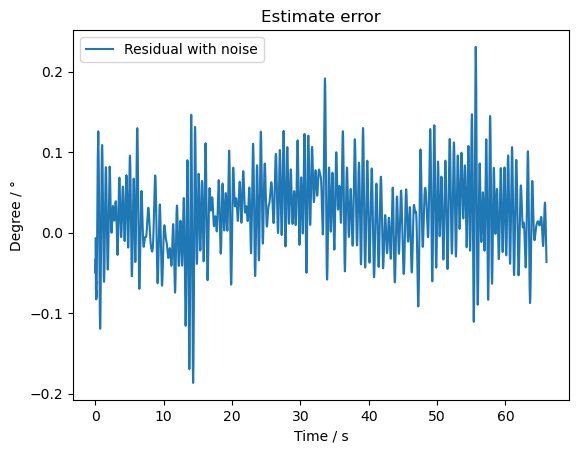

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(sensing_times_tiled, phase_error_tiled - x_est_n, label="Residual with noise")
ax1.set_title("Estimate error")
ax1.set_ylabel("Degree / °")
ax1.set_xlabel("Time / s")
ax1.legend()

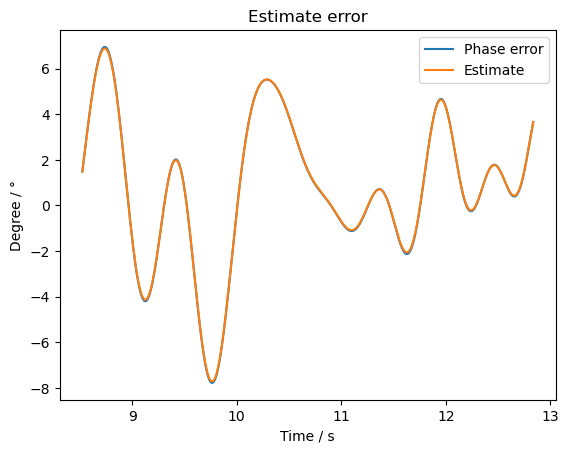

In [ ]:
fig, ax1 = plt.subplots()
ax1.plot(sensing_times_tiled[1000:1500], phase_error_tiled[1000:1500], label="Phase error")
ax1.plot(sensing_times_tiled[1000:1500], x_est_n[1000:1500], label="Estimate")
ax1.set_title("Estimate error")
ax1.set_ylabel("Degree / °")
ax1.set_xlabel("Time / s")
ax1.legend()

Text(0.5, 0, 'Time / s')

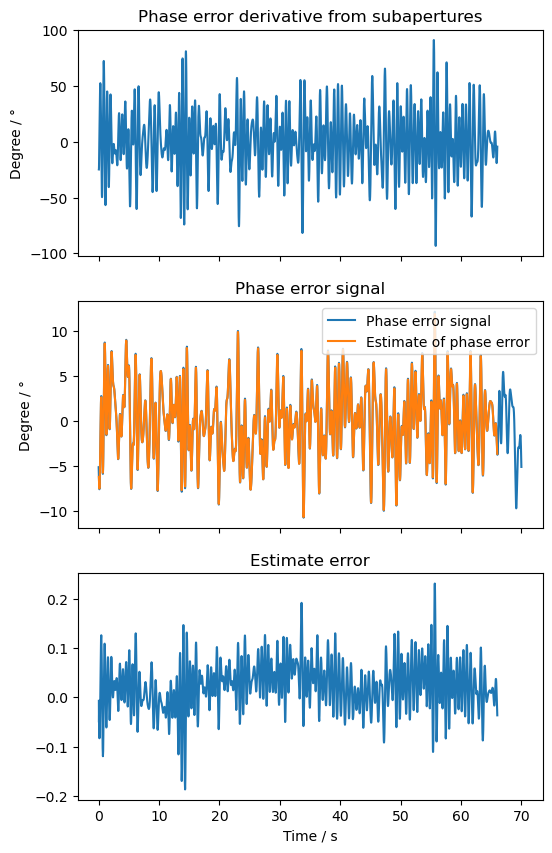

In [ ]:
(fig, (ax1, ax2, ax3)) = plt.subplots(3, 1, figsize=(6, 10), sharex=True)
ax1.plot(sensing_times_tiled, phase_error_der_n)
ax1.set_ylabel("Degree / °")
ax2.set_ylabel("Degree / °")
ax1.set_title("Phase error derivative from subapertures")
ax2.plot(
    time_phase,
    phase_error,
    label="Phase error signal"
)
ax2.set_title("Phase error signal")
ax2.plot(sensing_times_tiled, x_est_n, label="Estimate of phase error")
ax2.legend()
ax3.plot(sensing_times_tiled, phase_error_tiled - x_est_n)
ax3.set_title("Estimate error")
ax2.set_ylabel("Degree / °")
ax3.set_xlabel("Time / s")

In [ ]:
heigth_residual_iw1 = (
        np.deg2rad(phase_error_iw1 - x_est_n[time_iw1_ind])[:, np.newaxis]
        / (2 * np.pi)
        * h_amb_roi.sel(grg=mosaic_iw1.grg, az=mosaic_iw1.az)
)
height_corrected_iw1_n = mosaic_iw1.SSHA + heigth_residual_iw1
heigth_residual_iw2 = (
        np.deg2rad(phase_error_iw2 - x_est_n[time_iw2_ind])[:, np.newaxis]
        / (2 * np.pi)
        * h_amb_roi.sel(grg=mosaic_iw2.grg, az=mosaic_iw2.az)
)
height_corrected_iw2_n = mosaic_iw2.SSHA + heigth_residual_iw2
heigth_residual_iw3 = (
        np.deg2rad(phase_error_iw3 - x_est_n[time_iw3_ind])[:, np.newaxis]
        / (2 * np.pi)
        * h_amb_roi.sel(grg=mosaic_iw3.grg, az=mosaic_iw3.az)
)
height_corrected_iw3_n = mosaic_iw3.SSHA + heigth_residual_iw3
height_corrected_iw2_n["line"] = height_corrected_iw2_n.line + subswath_1_to_2_line_offset
height_corrected_iw3_n["line"] = height_corrected_iw3_n.line + subswath_1_to_3_line_offset
height_corrected_iw12_n = height_corrected_iw1_n.isel(
    grg=height_corrected_iw1_n.grg < height_corrected_iw2_n.grg.isel(grg=0)
).combine_first(height_corrected_iw2_n)
height_corrected_iw123_n = height_corrected_iw12_n.isel(
    grg=height_corrected_iw12_n.grg < height_corrected_iw3_n.grg.isel(grg=0)
).combine_first(height_corrected_iw3_n)

In [ ]:
heigth_residual_iw1_no_overlap = (
        np.deg2rad(phase_error_iw1 - x_est_no_overlap[time_iw1_ind])[:, np.newaxis]
        / (2 * np.pi)
        * h_amb_roi.sel(grg=mosaic_iw1.grg, az=mosaic_iw1.az)
)
height_corrected_iw1_no_overlap = mosaic_iw1.SSHA + heigth_residual_iw1_no_overlap
heigth_residual_iw2_no_overlap = (
        np.deg2rad(phase_error_iw2 - x_est_no_overlap[time_iw2_ind])[:, np.newaxis]
        / (2 * np.pi)
        * h_amb_roi.sel(grg=mosaic_iw2.grg, az=mosaic_iw2.az)
)
height_corrected_iw2_no_overlap = mosaic_iw2.SSHA + heigth_residual_iw2_no_overlap
heigth_residual_iw3_no_overlap = (
        np.deg2rad(phase_error_iw3 - x_est_no_overlap[time_iw3_ind])[:, np.newaxis]
        / (2 * np.pi)
        * h_amb_roi.sel(grg=mosaic_iw3.grg, az=mosaic_iw3.az)
)
height_corrected_iw3_no_overlap = mosaic_iw3.SSHA + heigth_residual_iw3_no_overlap
height_corrected_iw2_no_overlap["line"] = height_corrected_iw2_no_overlap.line + subswath_1_to_2_line_offset
height_corrected_iw3_no_overlap["line"] = height_corrected_iw3_no_overlap.line + subswath_1_to_3_line_offset
height_corrected_iw12_no_overlap = height_corrected_iw1_no_overlap.isel(
    grg=height_corrected_iw1_no_overlap.grg < height_corrected_iw2_no_overlap.grg.isel(grg=0)
).combine_first(height_corrected_iw2_no_overlap)
height_corrected_iw123_no_overlap = height_corrected_iw12_no_overlap.isel(
    grg=height_corrected_iw12_no_overlap.grg < height_corrected_iw3_no_overlap.grg.isel(grg=0)
).combine_first(height_corrected_iw3_no_overlap)

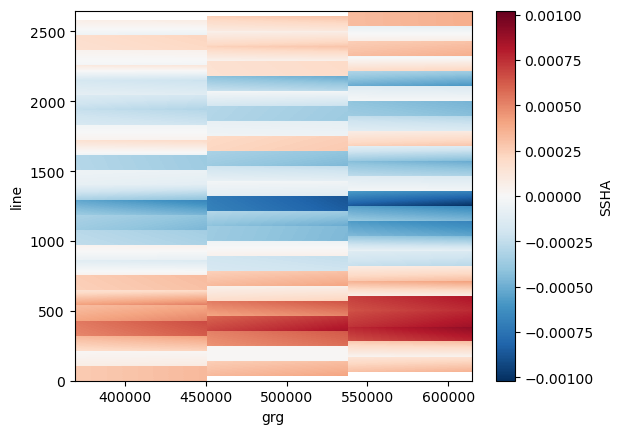

In [ ]:
(height_corrected_iw123_n - height_corrected_iw123_no_overlap).plot()

Text(0, 0.5, 'Line')

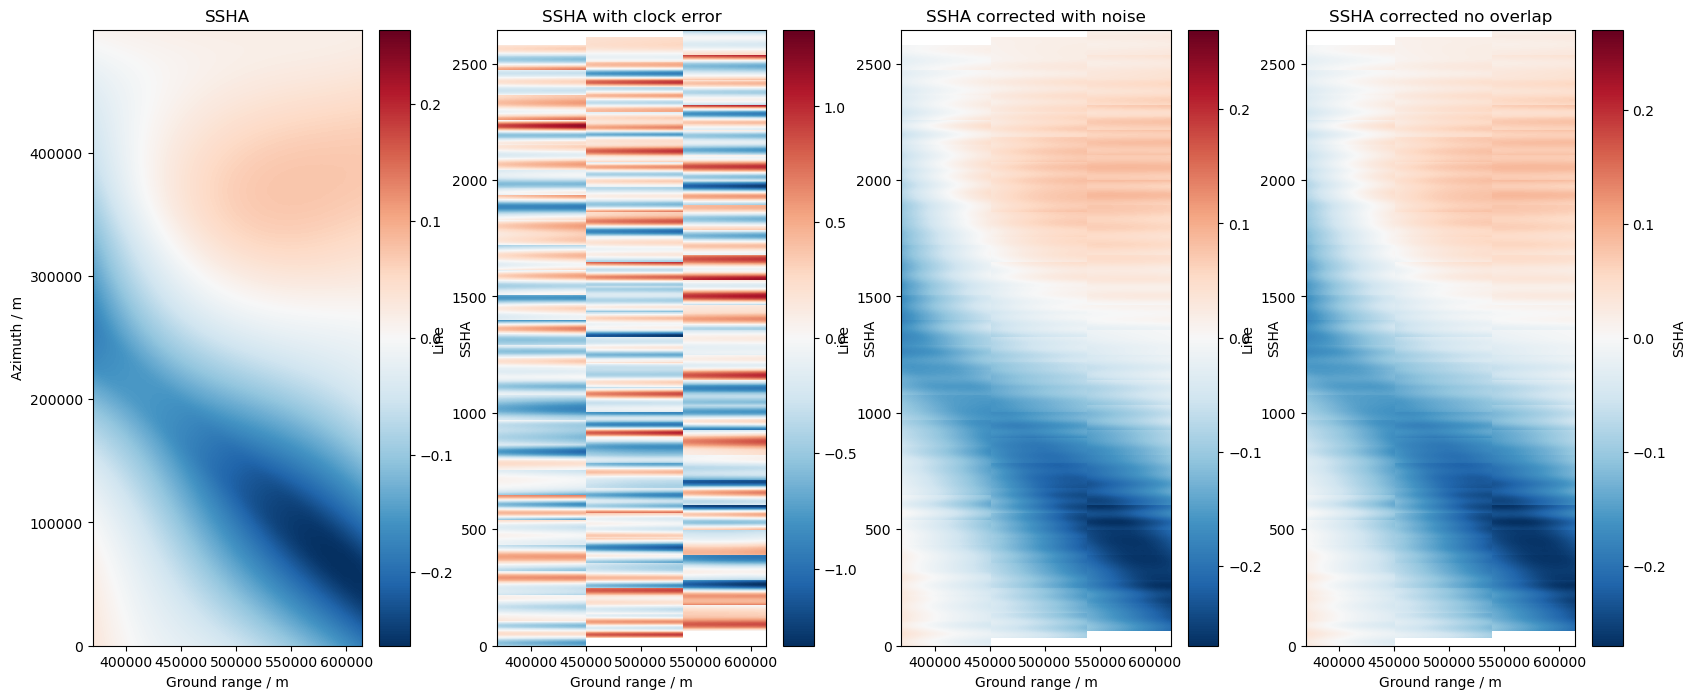

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
tc_ds.SSHA.plot(ax=ax1)
ax1.set_title("SSHA")
ax1.set_xlabel("Ground range / m")
ax1.set_ylabel("Azimuth / m")
mosaic_iw123.plot(ax=ax2)
ax2.set_title("SSHA with clock error")
ax2.set_xlabel("Ground range / m")
ax2.set_ylabel("Line")
height_corrected_iw123_n.plot(ax=ax3)
ax3.set_title("SSHA corrected with noise")
ax3.set_xlabel("Ground range / m")
ax3.set_ylabel("Line")
height_corrected_iw123_no_overlap.plot(ax=ax4)
ax4.set_title("SSHA corrected no overlap")
ax4.set_xlabel("Ground range / m")
ax4.set_ylabel("Line")

In [ ]:
iw1_noise = h_std_roi.sel(grg=mosaic_iw1.grg, az=mosaic_iw1.az) * rng.standard_normal(h_amb_roi.sel(grg=mosaic_iw1.grg, az=mosaic_iw1.az).shape)
iw2_noise = h_std_roi.sel(grg=mosaic_iw2.grg, az=mosaic_iw2.az) * rng.standard_normal(h_amb_roi.sel(grg=mosaic_iw2.grg, az=mosaic_iw2.az).shape)
iw3_noise = h_std_roi.sel(grg=mosaic_iw3.grg, az=mosaic_iw3.az) * rng.standard_normal(h_amb_roi.sel(grg=mosaic_iw3.grg, az=mosaic_iw3.az).shape)

In [ ]:
# Reset the offset so that the addition with h_std_roi works
height_corrected_iw2_n["line"] = height_corrected_iw2_n.line - subswath_1_to_2_line_offset
height_corrected_iw3_n["line"] = height_corrected_iw3_n.line - subswath_1_to_3_line_offset

height_corrected_iw1_measurement_n = height_corrected_iw1_n + iw1_noise

height_corrected_iw2_measurement_n = height_corrected_iw2_n + iw2_noise

height_corrected_iw3_measurement_n = height_corrected_iw3_n + iw3_noise

height_corrected_iw2_measurement_n["line"] = height_corrected_iw2_measurement_n.line + subswath_1_to_2_line_offset
height_corrected_iw3_measurement_n["line"] = (
    height_corrected_iw3_measurement_n.line + subswath_1_to_3_line_offset
)
height_corrected_iw12_measurement_n = height_corrected_iw1_measurement_n.isel(
    grg=height_corrected_iw1_measurement_n.grg
    < height_corrected_iw2_measurement_n.grg.isel(grg=0)
).combine_first(height_corrected_iw2_measurement_n)
height_corrected_iw123_measurement_n = height_corrected_iw12_measurement_n.isel(
    grg=height_corrected_iw12_measurement_n.grg
    < height_corrected_iw3_measurement_n.grg.isel(grg=0)
).combine_first(height_corrected_iw3_measurement_n)

Let's show the measurement noise

Text(0, 0.5, 'Line')

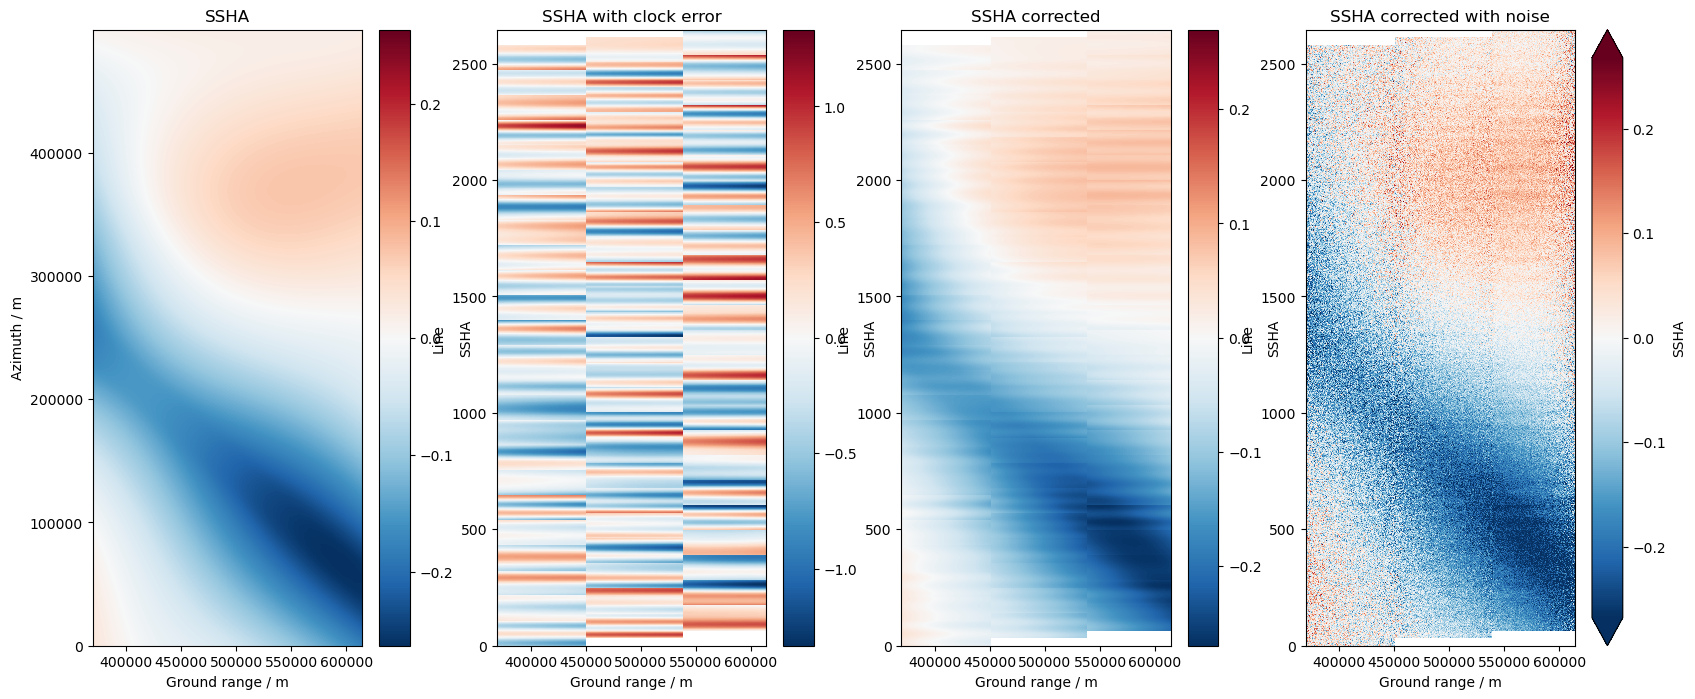

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
tc_ds.SSHA.plot(ax=ax1)
ax1.set_title("SSHA")
ax1.set_xlabel("Ground range / m")
ax1.set_ylabel("Azimuth / m")
mosaic_iw123.plot(ax=ax2)
ax2.set_title("SSHA with clock error")
ax2.set_xlabel("Ground range / m")
ax2.set_ylabel("Line")
height_corrected_iw123_n.plot(ax=ax3)
ax3.set_title("SSHA corrected")
ax3.set_xlabel("Ground range / m")
ax3.set_ylabel("Line")
height_corrected_iw123_measurement_n.plot(ax=ax4, robust=True)
ax4.set_title("SSHA corrected with noise")
ax4.set_xlabel("Ground range / m")
ax4.set_ylabel("Line")

In [ ]:
height_corrected_f_ds = xr.zeros_like(height_corrected_iw123_n)
height_corrected_f_ds += gaussian_filter(height_corrected_iw123_measurement_n, sigma=2, radius=1, mode="nearest")

In [ ]:
#height_corrected_f = signal.wiener(np.nan_to_num(height_corrected_iw123_measurement_n), (7, 7))

Text(0, 0.5, 'Line')

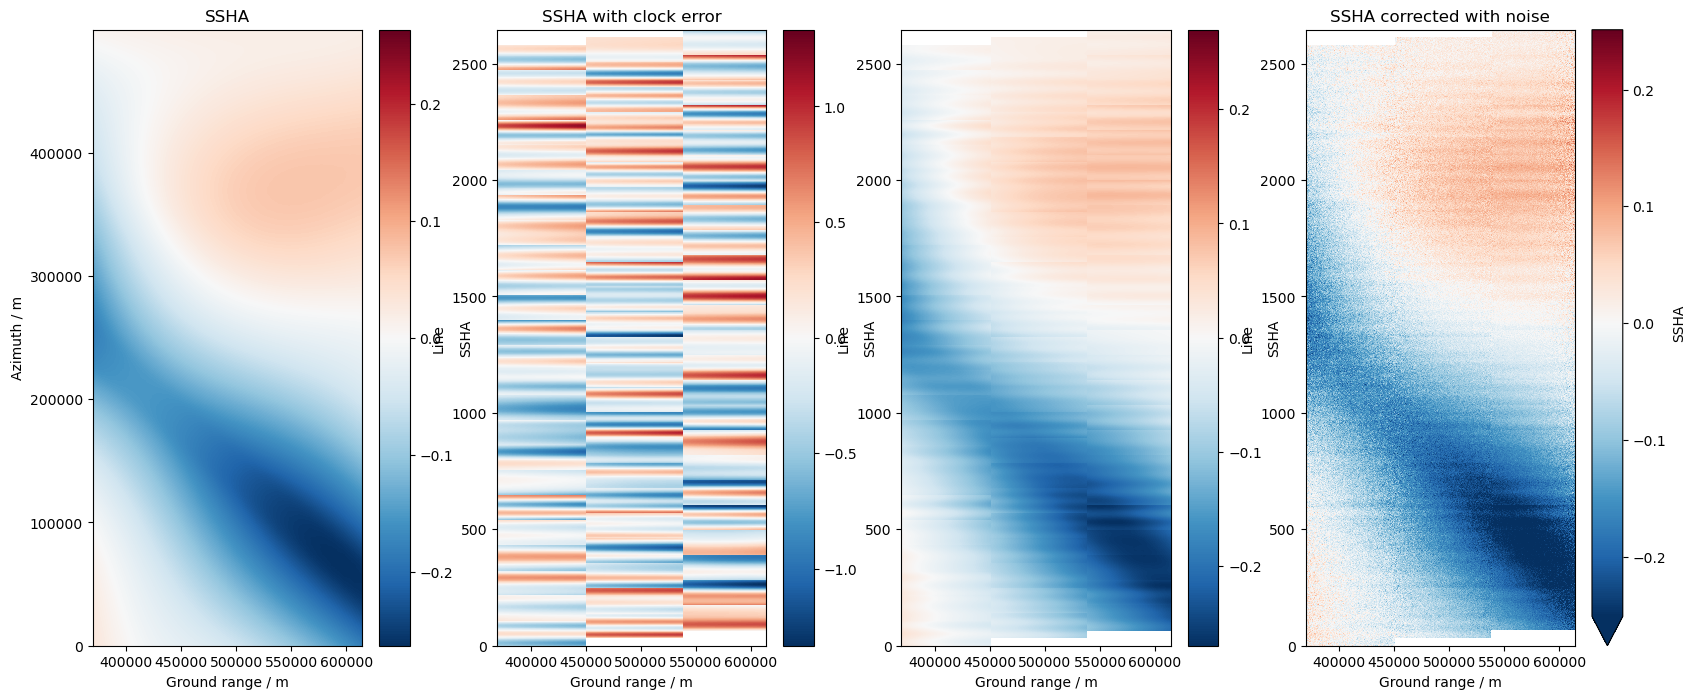

In [ ]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 8))
tc_ds.SSHA.plot(ax=ax1)
ax1.set_title("SSHA")
ax1.set_xlabel("Ground range / m")
ax1.set_ylabel("Azimuth / m")
mosaic_iw123.plot(ax=ax2)
ax2.set_title("SSHA with clock error")
ax2.set_xlabel("Ground range / m")
ax2.set_ylabel("Line")
height_corrected_iw123_n.plot(ax=ax3)
ax3.set_xlabel("Ground range / m")
ax3.set_ylabel("Line")
height_corrected_f_ds.plot(ax=ax4, robust=True)
ax4.set_title("SSHA corrected with noise")
ax4.set_xlabel("Ground range / m")
ax4.set_ylabel("Line")